# Activity
### Q2 Netflix 10+ Year Stock Data
#### Petrina 50%, Ivacek 50%

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

In [2]:
nflx_data = pd.read_csv('data/NFLX.csv')

# Display the first few rows of the dataset
nflx_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


## 4.1 EDA and data preprocessing 	(5b) 
### (A-4b)	EDA a data preprocessing pre Vami vybrané charakteristiky z datasetu 


### EDA

In [3]:
nflx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4581 non-null   object 
 1   Open       4581 non-null   float64
 2   High       4581 non-null   float64
 3   Low        4581 non-null   float64
 4   Close      4581 non-null   float64
 5   Adj Close  4581 non-null   float64
 6   Volume     4581 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 250.7+ KB


In [4]:
stats_summary = nflx_data.describe()
stats_summary

,Open,High,Low,Close,Adj Close,Volume
count,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4.581000e+03
mean,78.031471,79.285690,76.736079,78.072056,78.072056,1.760516e+07
std,118.372084,120.276839,116.376768,118.435303,118.435303,1.971130e+07
min,0.377857,0.410714,0.346429,0.372857,0.372857,2.856000e+05
25%,3.778571,3.857143,3.685714,3.784286,3.784286,6.908900e+06
50%,15.392858,15.671429,14.970000,15.324286,15.324286,1.155350e+07
75%,97.830002,99.529999,96.760002,97.889999,97.889999,2.113440e+07
max,567.979980,575.369995,520.960022,548.729980,548.729980,3.234140e+08


In [5]:
missing_values = nflx_data.isnull().sum()
missing_values

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

V datasete sa nevyskutuje ziadne chybajuceho hodnoty

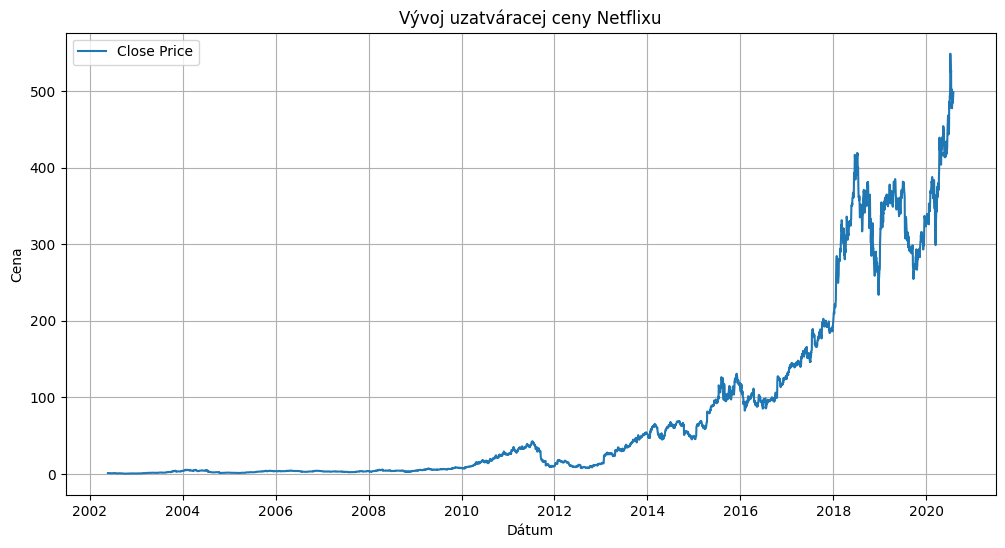

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(nflx_data['Date'], nflx_data['Close'], label='Close Price')
plt.title('Vývoj uzatváracej ceny Netflixu')
plt.xlabel('Dátum')
plt.ylabel('Cena')
plt.grid()
plt.legend()
plt.show()

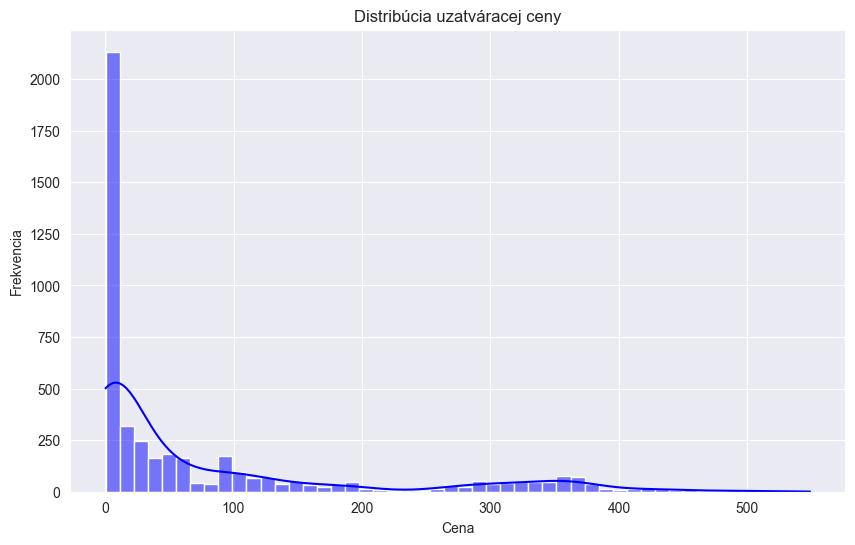

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(nflx_data['Close'], bins=50, kde=True, color='blue')
plt.title('Distribúcia uzatváracej ceny')
plt.xlabel('Cena')
plt.ylabel('Frekvencia')
plt.show()

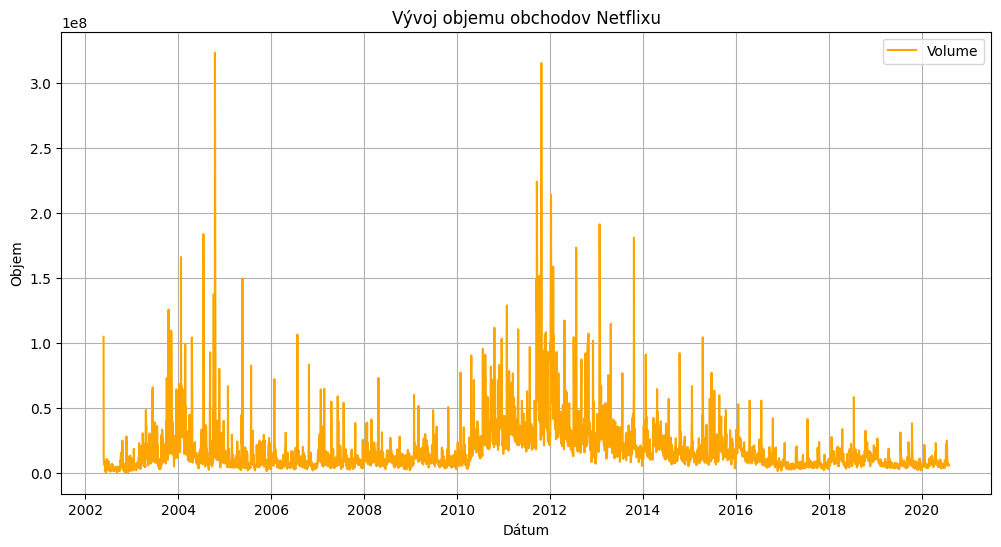

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(nflx_data['Date'], nflx_data['Volume'], label='Volume', color='orange')
plt.title('Vývoj objemu obchodov Netflixu')
plt.xlabel('Dátum')
plt.ylabel('Objem')
plt.grid()
plt.legend()
plt.show()

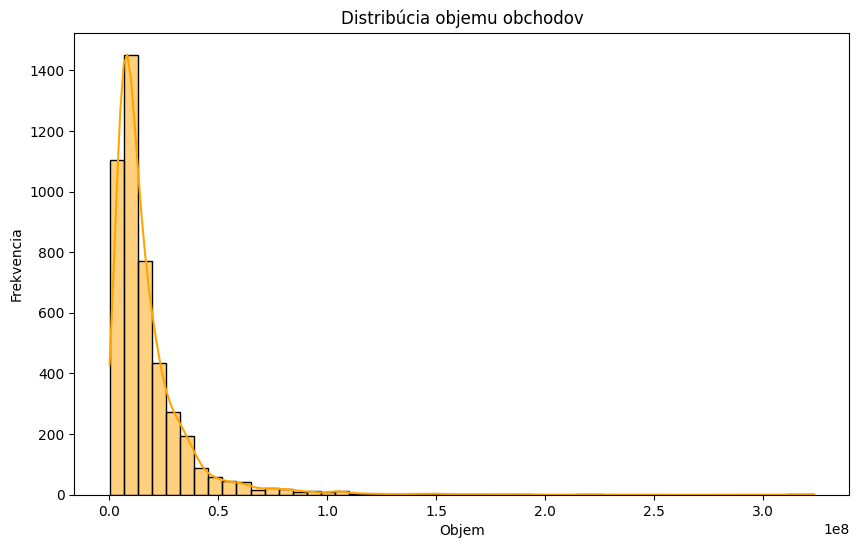

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(nflx_data['Volume'], bins=50, kde=True, color='orange')
plt.title('Distribúcia objemu obchodov')
plt.xlabel('Objem')
plt.ylabel('Frekvencia')
plt.show()

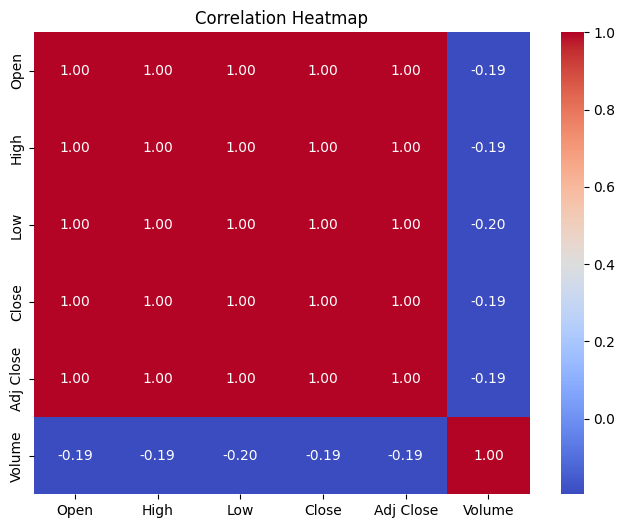

In [17]:
plt.figure(figsize=(8, 6))
correlation_matrix = nflx_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

#### Detekciu vychýlených hodnôt nebudeme riešiť pretože dáta odrážajú reálne udalosti ako prudké skoky alebo poklesy cien spôsobené trhovými udalostami ktoré môžu byt doležité pre predikciu

### Predspracovanie dát

In [7]:
# Zmenime typ Date z object na datetime
nflx_data['Date'] = pd.to_datetime(nflx_data['Date'])

In [9]:
# Predikciu použijeme Uzatváraciu cenu a Objem obchodov
selected_features = nflx_data[['Close', 'Volume']]

In [10]:
# Na normalizáciu dát použijeme MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(selected_features)

# Vytvorenie DataFrame so škálovanými hodnotami
scaled_features_df = pd.DataFrame(scaled_features, columns=['Close', 'Volume'])
scaled_features_df.head()

,Close,Volume
0,0.001502,0.323414
1,0.001527,0.033483
2,0.001430,0.019571
3,0.001333,0.020030
4,0.001274,0.030541


In [11]:
# Funkcia na vytvorenie sekvencií
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i+time_step])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [12]:
# Definovanie časového kroku
time_step = 60
X, Y = create_dataset(scaled_features, time_step)

In [13]:
# Rozdelenie dát na trénovaciu a testovaciu sadu 80% trening 20% testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((3616, 60, 2), (905, 60, 2), (3616,), (905,))

### (B-1b)	Zdôvodnite výber ML/DL metód vzhľadom na Vami vybraný dataset pre 4.2

#### Vybrali sme model Long Short-Term Memory(LSTM). Tento výber je zdôvodnený vlastnostami datasetu a schopnostami LSTM modelu. Dataset obsahuje časové rady s historickými údajmi o uzátváracej cene `Close` a objeme obchodov `Volume`. Hodnoty uzatváracích cien majú časové závislosti. Budúca hodnota závisí od predchádzajúcich hodnôt. Takisto Ceny akcií majú vysokú volatilitu ktorá môže zahŕňať krátkodobé aj dlhodobé vzory na čo je podla nás najlepší práve tento model.

## 4.2. Modeling and evaluation (5b)
### (A-4b)	Modeluje Vami tie vybrané charakteristiky pomocou vhodných ML/D metód. Výsledok modelovania je najlepší model.


### (B-1b)	Zhodnotíte Váš prístup a získaný výsledok